# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [105]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

### 1) Importer le tableau de données dans un dataframe 

In [2]:
# Import du dataframe "data.csv"
df = pd.read_csv('data.csv')

In [8]:
df.head(3)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes


In [10]:
df.describe()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
count,9565,9563,9582,9582,9488,9582
unique,1382,4,57,4,21,14
top,Ball Aerospace,Data scientist,SQL/R/Python//Big data,Master,"1,5",Paris
freq,748,3865,539,4971,1023,2015


### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [6]:
df.shape[0]

9582

Il y a `9582` lignes dans le dataset

In [82]:
df.isna().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

Il y a:
- `17` lignes ou il manque une **entreprise**
- `19` lignes ou il manque un **metier**
- `94` lignes ou il manque une **experience**

### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

Voyons comment sont répartis les valeurs manquante (pour la colone experience) entre les metiers

In [94]:
def get_exp_nan_by_metier_details():
    # Getting number of nan in `Experience` for each `Metier`
    df_isna = df.isna()
    df_isna["Metier"] = df["Metier"]
    final_df = df_isna[["Metier", "Experience"]].groupby("Metier", dropna=False).sum().rename(columns={'Experience': 'NaN number'})

    # Getting number of NOT nan in `Experience` for each `Metier`
    final_df["Not NaN number"] = df.groupby("Metier", dropna=False)["Experience"].count()

    # Computing percent of nan in `Experience` for each `Metier`
    final_df["NaN percent"] = final_df.apply(lambda r: r["NaN number"] / (r["NaN number"] + r["Not NaN number"]) * 100, axis=1)

    return final_df

get_exp_nan_by_metier_details()

,NaN number,Not NaN number,NaN percent
Metier,,,
Data architecte,0,2123,0.0
Data engineer,0,2347,0.0
Data scientist,0,3865,0.0
Lead data scientist,0,1228,0.0
NaN,0,19,0.0


-> Tous les metiers ont des lignes avec des valeurs manquantes pour l'experience (environ 1% des lignes).

-> Les lignes sans metier (à prédire) n'ont pas de valeur manquante pour l'experience

In [69]:
df["Experience"].dtypes

dtype('O')

La colone "Experience" est de type `object`, il faut la convertir en `float` pour pouvoir faire des calcules

In [72]:
df["Experience"] = df["Experience"].replace(",", ".", regex=True).astype(float)
df["Experience"].dtypes

dtype('float64')

On peut maintenant calculer:
- la medianne de l'experience des Data Scientist
- la moyenne de l'experience des Data Engineer

In [76]:
df_by_metier = df.groupby("Metier")

ds_median = df_by_metier.get_group("Data scientist")["Experience"].median()
de_mean = df_by_metier.get_group("Data engineer")["Experience"].mean()

print(f"Data scientist median experience: {ds_median}")
print(f"Data Engineer mean experience: {de_mean}")

Data scientist median experience: 2.0
Data Engineer mean experience: 2.984959174903309


Et remplacer les NaN

In [96]:
# Replacing NaN in `Experience` by the mean for Data Scientist
df.loc[(df["Metier"] == "Data scientist") & (df["Experience"].isna()), "Experience"] = ds_median
df.loc[(df["Metier"] == "Data engineer") & (df["Experience"].isna()), "Experience"] = de_mean

get_exp_nan_by_metier_details()

,NaN number,Not NaN number,NaN percent
Metier,,,
Data architecte,0,2123,0.0
Data engineer,0,2347,0.0
Data scientist,0,3865,0.0
Lead data scientist,0,1228,0.0
NaN,0,19,0.0


On remplace aussi les valeurs manquante dans `Experience` par la moyenne pour les autres valeurs de `Metier`

In [92]:
for metier in ["Data architecte", "Lead data scientist"]:
    metier_mean = df_by_metier.get_group(metier)["Experience"].mean()
    df.loc[(df["Metier"] == metier) & (df["Experience"].isna()), "Experience"] = metier_mean

In [95]:
get_exp_nan_by_metier_details()

,NaN number,Not NaN number,NaN percent
Metier,,,
Data architecte,0,2123,0.0
Data engineer,0,2347,0.0
Data scientist,0,3865,0.0
Lead data scientist,0,1228,0.0
NaN,0,19,0.0


=> Il n'y a plus de valeurs manquantes dans la colone `Experience`

### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [101]:
df.groupby("Metier").mean()

,Experience
Metier,
Data architecte,3.000476
Data engineer,2.984959
Data scientist,2.241268
Lead data scientist,3.965261


### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

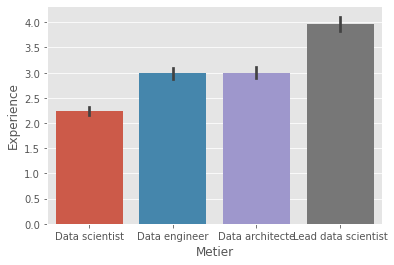

In [115]:
sns.barplot(x="Metier", y="Experience", data=df, order=["Data scientist", "Data engineer", "Data architecte", "Lead data scientist"])
plt.show()

Voila une représentation simple de la moyenne de l'experience pour chaque métier

Mais représenter simplement la moyenne "cache" des informations, comme la distribution. On peut utiliser, par exemple, des "boîte à moustaches" (**Box plot**) en complément pour représenter plus d'informations (médiane, quartiles, outliers...)

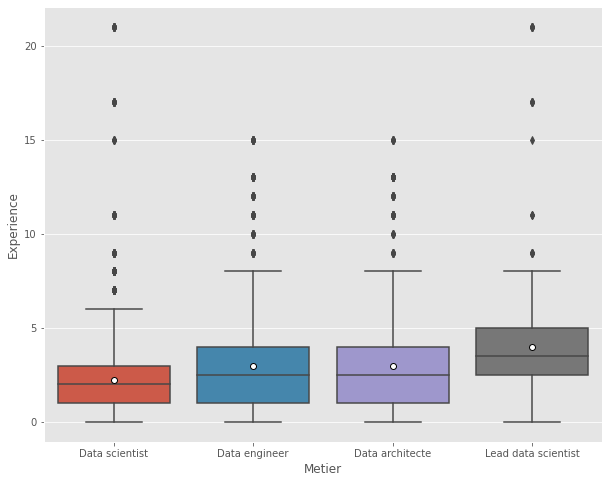

In [125]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x="Metier", y="Experience", data=df, showmeans=True, meanprops={"marker": "o", "markerfacecolor":"white", "markeredgecolor": "black"},
            order=["Data scientist", "Data engineer", "Data architecte", "Lead data scientist"], ax=ax)
plt.show()

On peut même combiner le "box plot" avec un "strip plot" pour voir les données directement

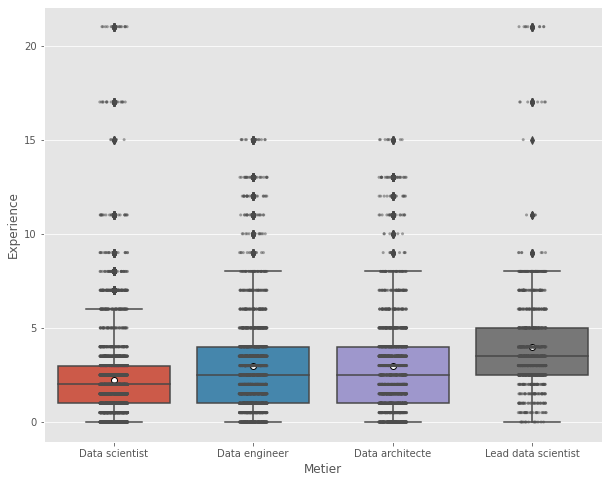

In [141]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x="Metier", y="Experience", data=df, showmeans=True, meanprops={"marker": "o", "markerfacecolor":"white", "markeredgecolor": "black"},
            order=["Data scientist", "Data engineer", "Data architecte", "Lead data scientist"], ax=ax)
sns.stripplot(x="Metier", y="Experience", data=df, color=".3", alpha=0.5, size=3,
            order=["Data scientist", "Data engineer", "Data architecte", "Lead data scientist"], ax=ax)
plt.show()

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

Pour séparer les données en 4 catégories, il faut que je définisse des valeurs limites entre chaque groupe. J'ai pensé à utiliser les quartiles: concrètement, un "avancé" auras plus d'experience que 50% des autres profiles, un "expert" lui, plus que 75% des autres profiles...

On peut observer les quartiles sur ce box plot:

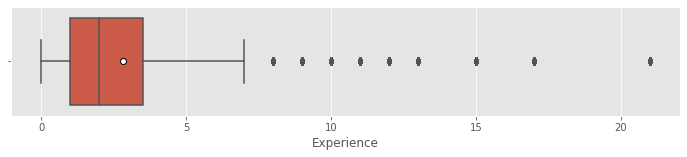

In [167]:
fig, ax = plt.subplots(figsize=(12, 2))
sns.boxplot(x=df["Experience"], showmeans=True, meanprops={"marker": "o", "markerfacecolor":"white", "markeredgecolor": "black"}, ax=ax)
# sns.stripplot(x=df["Experience"], data=df, color=".3", alpha=0.1, size=3, ax=ax)
plt.show()

`pd.qcut()` permet justement de diviser les lignes en groupe en fonction des quartiles

In [500]:
df["Exp_label"], bins = pd.qcut(df["Experience"], 4, labels=["débutant", "confirmé", "avancé", "expert"], retbins=True)
print(f"Bins limit: {bins}")

df.head(5)

Bins limit: [ 0.   1.   2.   3.5 21. ]


,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label
0,Sanofi,Data scientist,"[pyspark, scikit-learn, python, tensorflow, ma...",Master,1.0,Paris,débutant
1,Massachusetts General Hospital(MGH),Data architecte,"[java, python, mongodb, scala]",Master,3.0,Marseille,avancé
2,Delve,Lead data scientist,"[teradata, scikit-learn, r, python, tensorflow...",Master,3.0,Nantes,avancé
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,"[c++, python, java, c]",Master,1.5,Marseille,confirmé
4,Arm,Data scientist,"[c++, scikit-learn, python, tensorflow, numpy,...",Phd,2.0,Bordeaux,confirmé


On peut évaluer visuellement à quel point `Exp_label` "divise" les `Metier` avec ce _diagramme à barres_ qui montre le nombre de profile dans chaque métier pour chaque catégorie de `Exp_label` :

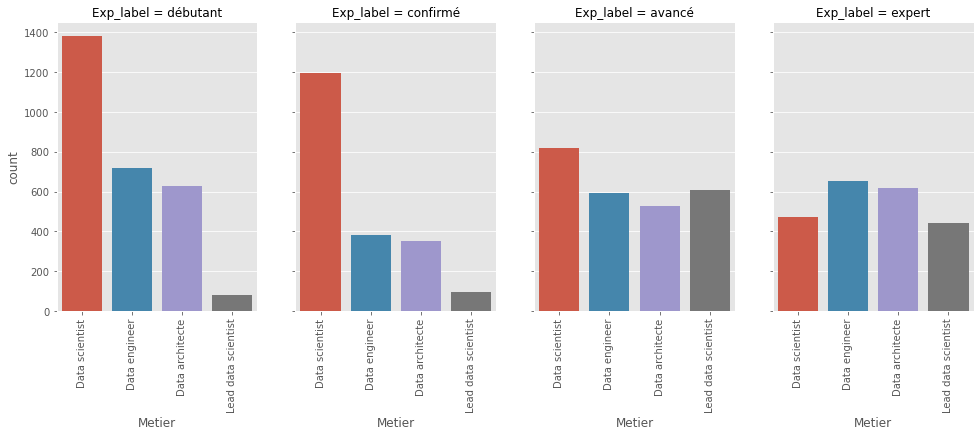

In [491]:
f_grid = sns.catplot(x="Metier", col="Exp_label", data=df, kind="count", height=5, aspect=.7,
            order=["Data scientist", "Data engineer", "Data architecte", "Lead data scientist"])

for grid_line in f_grid.axes:
    for sub_ax in grid_line:
        sub_ax.set_xticklabels(sub_ax.get_xticklabels(), rotation=90)
plt.show()

### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

In [211]:
print(df["Technologies"].dtype)
print(type(df["Technologies"][0]))

object
<class 'str'>


Les technologies sont sous forme de string et non de liste, il va falloir les convertir.

On nettoi aussi un peu les données:
- En supprimant les doubles slash `//`, qui créent une techno "vide" (`""`)
- En mettant en miniscule tout les caractères (pour ne pas différencier `"machine learning"` et `"Machine learning"` par exemple)
- En évitant qu'un profile ai renseigné 2 fois la même technologie et fausse les comptes (avec un `set()`)
- En traitant quelques cas particuliers:
  - Je ne crois pas que la technologie `"NoSQ"` existe, il sagit surement d'une faute de frappe pour `"NoSQL"`. Il va falloir corriger ça.
  - Dans nos listes, il existe les technologie `"Hadoop(HDFS)"`, `"Hadoop"` et `"HDFS"` qui sont similaire. Je pense convertir `"Hadoop(HDFS)"` en `"Hadoop"` et `"HDFS"`.

In [305]:
df["Technologies"] = df["Technologies"].apply(lambda str_lst: list(set(
    re.sub(r"nosq(?!l)", "nosql", str_lst
        .lower()
        .replace("//", "/")
        .replace("hadoop(hdfs)", "hadoop/hdfs")
    ).split("/")
)))

print(type(df["Technologies"][0]))

<class 'list'>


On peut maintenant les compter, en comptant bien les éléments dans chaque liste (et pas les listes directement)

In [309]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

techo_count = to_1D(df["Technologies"]).value_counts()
techo_count.head(5)

python    6627
r         4374
sql       2581
java      1719
hadoop    1687
dtype: int64

Les 5 technologies les plus utilisées sont : le Python, le R, le SQL, le Java et Hadoop

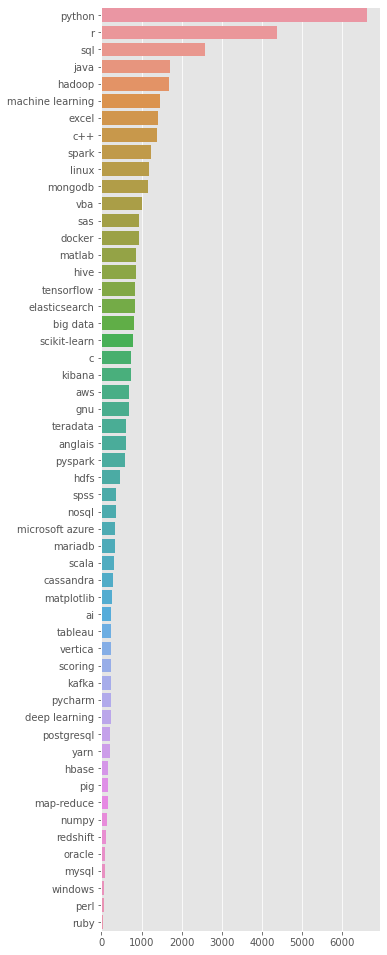

In [310]:
fig, ax = plt.subplots(figsize=(5, 17))
sns.barplot(x=techo_count.values, y=techo_count.index, ax=ax)
plt.show()

In [362]:
# # Creating a correlation heatmap between technologies

# one_hot_techno = df["Technologies"].str.join('|').str.get_dummies()
# techno_corr = one_hot_techno.corr(method="pearson")

# fig, ax = plt.subplots(figsize = (17,13))
# # mask=np.triu(techo_count)
# sns.heatmap(techno_corr, mask=np.eye(techo_count.shape[0]),  square=True, linewidths=.5, cmap="Blues")
# plt.xticks(rotation=90)
# plt.show()


### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

Il faut préprocesser les données :
- Gérer les valeurs manquantes :
  - Pour `Experience` : déjà fait, on remplace par la medianne
  - Pour `Metier` : ce seront des ligne a prédire plus tard, on peu les enlever
  - Pour `Entreprise` : il n'en manque que 17, on peu les enlever
- Preprocess `Technologies` : (déjà fait)
- Preprocess `Entreprise` : minimiser la case des noms (pour que, par exemple, `"Somalogic, Inc."` et `"SomaLogic, Inc."` soit la même entreprise)
- Transformer des features
  - Creer `Exp_label`: déjà fait (question 4)
- Encoder les _categorical features_ :
  - `Entreprise` avec du "one hot encoding"
  - `Metier` avec du "one hot encoding"
  - Les liste dans `Technologies` avec du "one hot encoding"
  - `Diplome` avec du "ordinal encoding"
  - `Exp_label` avec du "ordinal encoding"

In [734]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

def convert_column_to_float(df, column):
    df["Experience"] = df["Experience"].replace(",", ".", regex=True).astype(float)

def replace_nan_by_categorical_median(df, column, cat_col, param):
    P_KEY = f"{column}_median"
    if P_KEY not in param:
        param[P_KEY] = df.groupby(cat_col)[column].median().to_dict()

    for cat in df[cat_col].unique():
        df.loc[(df[cat_col] == cat) & (df[column].isna()), column] = param[P_KEY].get(cat, df.loc[df[cat_col] == cat, column].median())

def drop_nan(df, column):
    df.dropna(subset=[column], inplace=True)

def lower_column(df, column):
    df[column] = df[column].str.lower()

def drop_column(df, column):
    df.drop(column, axis=1, inplace=True)

def ordinal_encoding(df, column, ordered_cat_lst, param):
    P_KEY = f"{column}_ordinal_encoder"
    if P_KEY not in param:
        param[P_KEY] = OrdinalEncoder(categories=[ordered_cat_lst])
        param[P_KEY].fit(df[[column]])

    df[f"{column}_encoded"] = param[P_KEY].transform(df[[column]])

def one_hot_encoding(df, column, param):
    P_KEY = f"{column}_one_hot_encoder"
    if P_KEY not in param:
        param[P_KEY] = OneHotEncoder()
        param[P_KEY].fit(df[[column]])

    ohe_result = param[P_KEY].transform(df[[column]])
    ohe_df = pd.DataFrame(
        ohe_result.toarray().astype(int),
        columns=[f"{column}_{cat}" for cat in param[P_KEY].categories_[0]],
        index=df.index
    )
    return df.join(ohe_df)

def list_to_one_hot_encoding(df, column):
    one_hot = df[column].str.join('|').str.get_dummies().add_prefix(f"{column}_")
    return df.join(one_hot)

def preprocess_technologies(df):
    df["Technologies"] = df["Technologies"].apply(lambda str_lst: list(set(
        re.sub(r"nosq(?!l)", "nosql", str_lst
            .lower()
            .replace("//", "/")
            .replace("hadoop(hdfs)", "hadoop/hdfs")
        ).split("/")
    )))

def create_exp_label(df, param):
    KEY = "Experience_bins"
    labels = ["débutant", "confirmé", "avancé", "expert"]

    if KEY not in param:
        df["Exp_label"], param[KEY] = pd.qcut(df["Experience"], 4, labels=labels, retbins=True)
    else:
        df["Exp_label"] = pd.cut(df["Experience"], param[KEY], include_lowest=True, labels=labels)  


In [805]:
def preprocess_for_clutering(df, param=None):
    if param is None:
        param = {}

    df = df.copy()

    # 1. Missing values

    # Exeprience
    convert_column_to_float(df, "Experience")
    replace_nan_by_categorical_median(df, "Experience", "Metier", param)

    # Metier (to predict)
    drop_nan(df, "Metier")


    # 2. Preprocess some columns
    preprocess_technologies(df)
    lower_column(df, "Entreprise")


    # # 3. Transform features
    create_exp_label(df, param)


    # 4. Encode categorical features
    df = one_hot_encoding(df, "Metier", param)
    drop_column(df, "Metier")
    
    df = list_to_one_hot_encoding(df, "Technologies")
    drop_column(df, "Technologies")
    
    # ordinal_encoding(df, "Diplome", ['No diploma', 'Bachelor', 'Master', 'Phd'], param)
    drop_column(df, "Diplome")


    # 5. Droping some columns

    # ordinal_encoding(df, "Exp_label", ["débutant", "confirmé", "avancé", "expert"], param)
    drop_column(df, "Exp_label")
    drop_column(df, "Experience")

    # df = one_hot_encoding(df, "Entreprise")
    drop_column(df, "Entreprise")
    
    # df = one_hot_encoding(df, "Ville", param)
    drop_column(df, "Ville")


    return df, param

In [806]:
from sklearn.cluster import KMeans
SEED = 42

# Preprocessing
df = pd.read_csv("data.csv")
train_df, preprocess_param = preprocess_for_clutering(df)

# Training
kmeans = KMeans(n_clusters=2, random_state=SEED).fit(train_df)

# Prediciton
train_df["cluster"] = kmeans.predict(train_df)

# Create new DataFrame to analyze result
df_cluster = df.join(train_df["cluster"])
drop_nan(df_cluster, "cluster")
preprocess_technologies(df_cluster)
convert_column_to_float(df_cluster, "Experience")
create_exp_label(df_cluster, preprocess_param)

df_cluster.head(3)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,cluster,Exp_label
0,Sanofi,Data scientist,"[pyspark, scikit-learn, python, tensorflow, ma...",Master,1.0,Paris,0.0,débutant
1,Massachusetts General Hospital(MGH),Data architecte,"[java, python, mongodb, scala]",Master,3.0,Marseille,1.0,avancé
2,Delve,Lead data scientist,"[teradata, scikit-learn, r, python, tensorflow...",Master,3.0,Nantes,0.0,avancé


#### Metrics

In [807]:
silhouette_mean = sk.metrics.silhouette_score(train_df[train_df.columns[:-1]], train_df["cluster"])
print(f"Silhouette score: {silhouette_mean:.3f}")

Silhouette score: 0.187


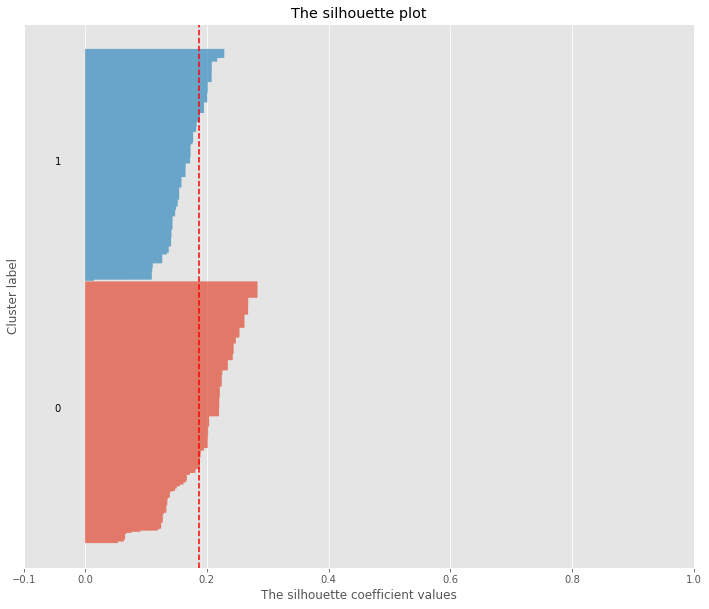

In [808]:
# Silhoutte plot
fig, ax = plt.subplots(figsize=(12, 10))

slihoutte_val = sk.metrics.silhouette_samples(train_df[train_df.columns[:-1]], train_df["cluster"])

y_lower = 10
for i in train_df["cluster"].unique():
    cluster_val = slihoutte_val[train_df["cluster"] == i]
    cluster_val.sort()

    y_upper = y_lower + cluster_val.shape[0]
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_val,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * cluster_val.shape[0], str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("The silhouette plot")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_mean, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [809]:
true_label = df_cluster["Metier"].replace(
    ['Data scientist', 'Data architecte', 'Lead data scientist', 'Data engineer'],
    [0, 1, 0, 1]
)
rand_score = sk.metrics.rand_score(true_label, df_cluster["cluster"])
adjusted_rand_score = sk.metrics.adjusted_rand_score(true_label, df_cluster["cluster"])
print(f"Rand Index: {rand_score:.2f}")
print(f"Adjusted Rand Index: {adjusted_rand_score:.2f}")


Rand Index: 1.00
Adjusted Rand Index: 0.99


#### Analyse des clusters

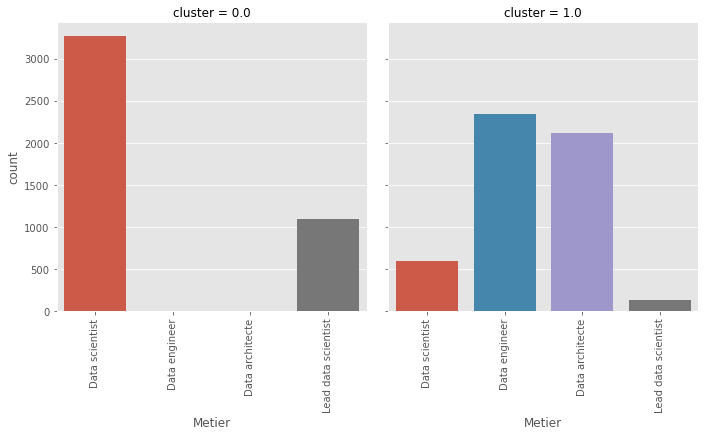

In [791]:
f_grid = sns.catplot(x="Metier", col="cluster", data=df_cluster, kind="count", height=5, aspect=1,
            order=["Data scientist", "Data engineer", "Data architecte", "Lead data scientist"])

for grid_line in f_grid.axes:
    for sub_ax in grid_line:
        sub_ax.set_xticklabels(sub_ax.get_xticklabels(), rotation=90)
plt.show()

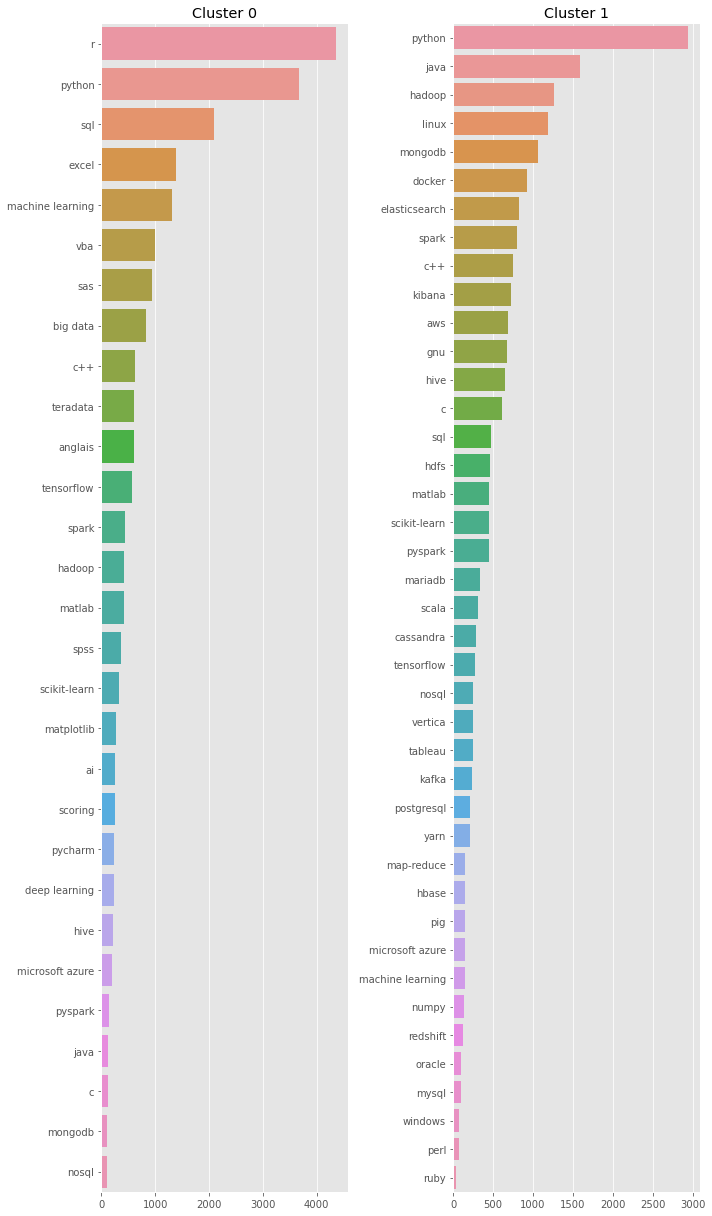

In [792]:
c0_tech_count = to_1D(df_cluster[df_cluster["cluster"] == 0]["Technologies"]).value_counts()
c1_tech_count = to_1D(df_cluster[df_cluster["cluster"] == 1]["Technologies"]).value_counts()


fig, ax = plt.subplots(1,2, figsize=(10, 17))
sns.barplot(x=c0_tech_count.values, y=c0_tech_count.index, ax=ax[0])
sns.barplot(x=c1_tech_count.values, y=c1_tech_count.index, ax=ax[1])

ax[0].title.set_text("Cluster 0")
ax[1].title.set_text("Cluster 1")
fig.tight_layout()
plt.show()

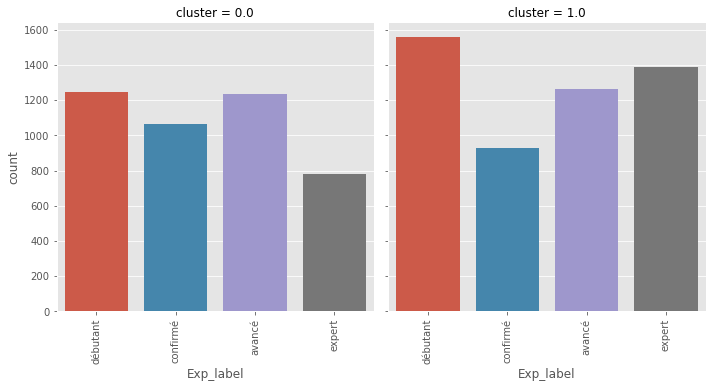

In [793]:
f_grid = sns.catplot(x="Exp_label", col="cluster", data=df_cluster, kind="count", height=5, aspect=1)

for grid_line in f_grid.axes:
    for sub_ax in grid_line:
        sub_ax.set_xticklabels(sub_ax.get_xticklabels(), rotation=90)
plt.show()

### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

In [ ]:
from sklearn.model_selection import train_test_split

new_df = pd.read_csv("data.csv")

train_df, test_df = train_test_split(test_size=0.3,)
# train_df, preprocess_param = preprocess_dataset(train_df)
# test_df, _ = preprocess_dataset(test_df, param=preprocess_param)